In [1]:
import numpy as np
from scipy.integrate import simps 
import matplotlib.pyplot as plt
from braket.circuits import Circuit
from braket.devices import LocalSimulator

In [2]:
# This cell defines the constants used throughout code

# Definition of the dimension d of each subsystem A and B, the frequency w, the number of partitions p and shots
d = 4
w = 0.1
p = 25
shots = 100000

In [3]:
# Number of qubits q needed for the entire system based on the dimension d
q = 2 * int(np.ceil(np.log(d) / np.log(2)))

# Creates the backend
backend = LocalSimulator()

In [4]:
# Initialize the analytical number of non-null Walsh angles and the angles/indices arrays
num_angles = int(q**2/4 + q)
a_j = np.zeros(num_angles, dtype=int)
indices = np.zeros(num_angles, dtype=int)

# Pre-calculate constants for angle computations
result_h1 = -(8**(q/2))*(1+2**(q/2))/8
result_h2 = (4**q)/16

# Calculate angles and indices
for j1 in range(int(q/2)):
    base_index = j1 + (j1+1)*int(q/2)
    
    a_j[j1] = result_h1/(2**j1)
    a_j[base_index] = a_j[j1]
    
    indices[j1] = 2**j1
    indices[base_index] = 2**(j1 + int(q/2))

    for j2 in range(int(q/2)):
        offset_index = base_index + j2 + 1
        a_j[offset_index] = result_h2/(2**(j2+j1))
        indices[offset_index] = indices[base_index] + 2**j2

In [5]:
# This cell is complementary to the previous cell. Here we apply for both the original n qubit system and its copy all the cnots and z-rotations 
# This will result in the desired evolved state.

def gates(QC,position,c,t):
    binary_str = format(indices[position], f'0{q}b')[::-1]    
    msb_index = binary_str.rfind('1')

    #Applies the cnots (to the right of the z-rotation gate) for current a_j
    for i in range(q):
        if binary_str[i] == '1':
            if i != msb_index:
                QC.cnot(i + 1 + c*q, msb_index + 1 + c*q)
    
    # Applies rotation gate to the current qubit
    theta_j = 2*a_j[position]*w*t/(2**q)
    QC.rz(msb_index + 1 + c*q, theta_j)
    
    # Applies cnots in reverse order
    for i in reversed(range(q)):
        if binary_str[i] == '1':
            if i != msb_index:
                QC.cnot(i + 1 + c*q, msb_index + 1 + c*q)

In [6]:
# This cell defines a loop that calculates the reduced purity as function of time 

# Create a list for the values of t and the reduced purity (trace)
t_val = []
Tr_val = []

# Defines a loop in time t for half the period T = 2pi/w of the reduced purity. 
for t in np.linspace(0, np.pi / w, p):
    t_val.append(t)
    print ("Tempo:",t)
    QC = Circuit()
    for r in range(1,2*q+1):
        QC.h(r)

    # Implement the unitary gate U(t) and thus the evolved state
    for c in range(2):
        for position in range(num_angles):
            gates(QC,position,c,t)
            
    # Apply the SWAP test for reduced purity estimation
    QC.h(0)
    for cswap in range(1, int(q/2) + 1):
        QC.cswap(0, cswap, cswap + q)
    QC.h(0)
    QC.measure(0)

    # Run the simulation 
    job = backend.run(QC, shots = shots)
    result = job.result()
    counts = result.measurement_counts
    count_0 = counts.get('0', 0)

    # Calculate the probability p0 of obtaining the |0> state for the ancilla qubit 
    p0 = count_0 / shots

    # Calculate the reduced purity using the probabilities p0
    Tr = 2*p0 - 1
    Tr_val.append(Tr)

Tempo: 0.0
Tempo: 1.3089969389957472
Tempo: 2.6179938779914944
Tempo: 3.9269908169872414
Tempo: 5.235987755982989
Tempo: 6.544984694978736
Tempo: 7.853981633974483
Tempo: 9.16297857297023
Tempo: 10.471975511965978
Tempo: 11.780972450961725
Tempo: 13.089969389957473
Tempo: 14.39896632895322
Tempo: 15.707963267948966
Tempo: 17.016960206944713
Tempo: 18.32595714594046
Tempo: 19.634954084936208
Tempo: 20.943951023931955
Tempo: 22.252947962927703
Tempo: 23.56194490192345
Tempo: 24.870941840919198
Tempo: 26.179938779914945
Tempo: 27.488935718910692
Tempo: 28.79793265790644
Tempo: 30.106929596902187
Tempo: 31.41592653589793


In [7]:
# Calculate the divisors of the integer n
def get_all_divisors(n):
    # Initialize a list to store all divisors
    divisors = set()
    
    # Loop to find divisors
    for i in range(1, int(n ** 0.5) + 1):
        if n % i == 0:
            # If i is a divisor, n // i is also a divisor
            divisors.add(i)
            divisors.add(n // i)
    
    # Return the divisors in ascending order
    return sorted(divisors)

# Functions for calculating analytical Fourier modes and reduced purity
def results(n):
    # Auxiliary function for Fourier mode calculations
    divisors = get_all_divisors(n)
    z = len(divisors) - 1
    R = sum(divisors)
    z_red = int(np.ceil(z/2))
    s = 0
    zt = z + 1
    for i in range(z_red, z + 1):
        if divisors[i] >= 2**(q/2):
            if divisors[i] != divisors[z - i]:
                s += divisors[i] + divisors[z - i]
                zt -= 2
            else:
                s += divisors[i]
                zt -= 1
    return R - s, zt

def calc_alpha_n_analyt(n):
    # Analytical calculation of Fourier modes
    Rt, Zt = results(n)
    if n <= (2**(q/2)-1)*(2**(q/2)-1):
        return 4 / (4**q) * (Zt * (2**q + n) - (2**(q/2 + 1)) * Rt)
    else:
        return 0

def Trace_analytical(t):
    # Analytical calculation of the trace/reduced purity
    Tr_part = sum(calc_alpha_n_analyt(v) * np.cos(v * w * t) for v in range(1, int((2**(q/2) - 1)**2 + 1)))
    Tr_analit = ((2 * 8**(q/2) - 2**q) / 4**q) + Tr_part
    return Tr_analit

C:\Users\victo\AppData\Local\Temp\ipykernel_14892\2369128594.py:16: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  result = simps(integrando, x=t_val)


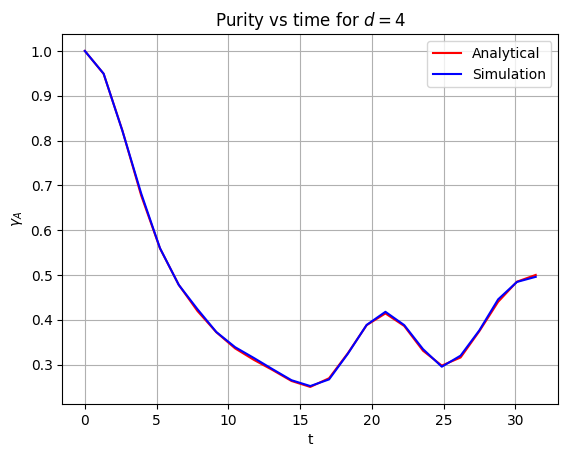

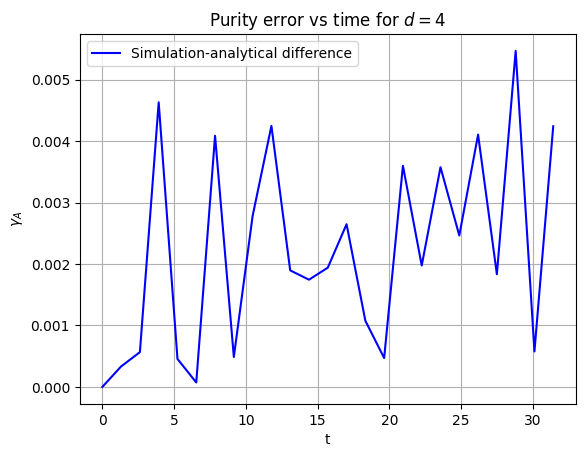

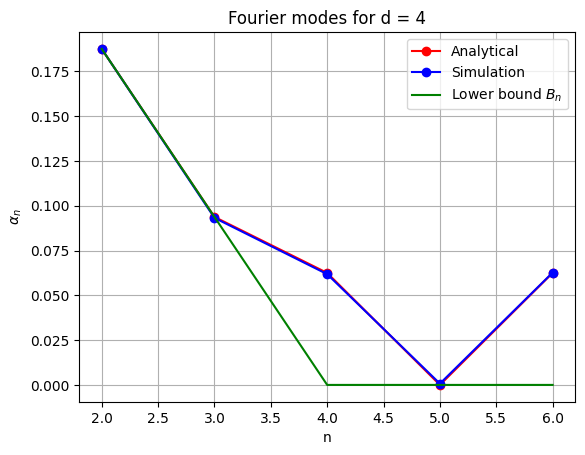

In [8]:
#This cell does all the numerically relevant calculations for graphing analysis. 

# Creates a time array for further integration
t_val = np.array(t_val)

# Creates the range of the integers for which the primality analysis can be reliably done
n_val = np.arange(2,2*(2**(q/2))-1)

# Creates numpy arrays for the lists of the numerical trace and analytical trace
Tr_val = np.array(Tr_val)
Tr_val_analyt = np.array(Trace_analytical(t_val))

# Integral over half the period T for the numerical reduced purity (trace), this gives the Fourier modes
def calc_alpha_n(n):
    integrando = (2*w/np.pi)*Tr_val*np.cos(n * w * t_val)
    result = simps(integrando, x=t_val)
    return result

# Defines the analytical expression for the Fourier modes bound in the defined interval of integers, to which all primes belong
def analytical_bound(n):
    if n in range(2,int(2**(q/2))):
        line = (8/2**(2*q))*(-(2**(q/2)-1)*n + 2**(q/2)*(2**(q/2)-1))
    else:
        line = 0
    return line

#This part registers as arrays the values of the numerical and analytical Fourier modes, as well as the bound 
alpha_n = np.array([calc_alpha_n(n) for n in n_val])
alpha_n_analyt = np.array([calc_alpha_n_analyt(n) for n in n_val])
bound_n = [analytical_bound(n) for n in n_val]

# First graph. Plots the numerical trace and the analytical trace
plt.plot(t_val, Tr_val_analyt, label=f'Analytical', color='red')
plt.plot(t_val, Tr_val, linestyle='-' , label=f'Simulation', color='blue')
plt.xlabel('t')
plt.ylabel(r'$\gamma_A$')
plt.title(f'Purity vs time for $d = {d}$')
plt.grid(True)
plt.legend()
plt.show()

# Second graph. Plots the absolute diference of the numerical trace and the analytical Trace
plt.plot(t_val, np.abs(Tr_val_analyt - Tr_val), label=f'Simulation-analytical difference', color='blue')
plt.xlabel('t')
plt.ylabel(r'$\gamma_A$')
plt.title(f'Purity error vs time for $d = {d}$')
plt.grid(True)
plt.legend()
plt.show()

# Third graph. Plots the Fourier modes for the numerical result, the analytical result and the lower bound
plt.figure()
plt.plot(n_val, alpha_n_analyt, marker='o', linestyle='-', label=f'Analytical', color='red')
plt.plot(n_val, alpha_n, marker='o', linestyle='-', label=f'Simulation', color='blue')
plt.plot(n_val, bound_n, label=f'Lower bound $B_n$', color='green')
plt.xlabel('n')
plt.ylabel(r'$\alpha_n$')
plt.title(f'Fourier modes for d = {d}')
plt.grid(True)
plt.legend()
plt.show()